In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing as skp 
import utils as ut
import netutils as net

In [2]:
# Let us read the logs into the various files 
# For each log, we will map source and destinations IP to local IPV4 format. 
# To do this, we define a new routine that uses the mapping_dict stored to do the mappings and read files. 

mapping_dict=ut.read_as_dict('unsw/mapping.csv','Original','Mapped')
conn_df = net.read_n_map('unsw/day_logs/conn.log', mapping_dict)
http_df = net.read_n_map('unsw/day_logs/http.log', mapping_dict)
dns_df = net.read_n_map('unsw/day_logs/dns.log', mapping_dict)
HOUR='Hour'

conn_df = net.add_hour(conn_df, field_name=HOUR, local_prefix='192.168.1')
excluded_devices = ['192.168.1.1', '192.168.1.208', '192.168.1.228', '192.168.1.236', '192.168.1.236']
conn_df = conn_df[~conn_df[net.SRC_IP].isin(excluded_devices)]

In [3]:
dns_df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,...,rcode,rcode_name,AA,TC,RD,RA,Z,answers,TTLs,rejected
0,1.474726e+09,Cmq5BD4abGJE9M6Dn6,192.168.1.166,45136,192.168.1.1,53,udp,31287,0.284601,babyws.withings.net,...,0.0,NOERROR,False,False,True,True,0,[89.30.121.150],[600.0],False
1,1.474726e+09,CqS2E81hhnbbAo7xH9,192.168.1.120,37616,192.168.1.1,53,udp,379,0.000366,sip.invoxia.com,...,0.0,NOERROR,False,False,True,True,0,[46.105.38.79],[602.0],False
2,1.474726e+09,CLGxUt3vdwASMqHn66,192.168.1.196,4355,192.168.1.1,53,udp,159,0.004368,pool.ntp.org,...,0.0,NOERROR,False,False,True,True,0,"[27.124.125.250, 129.250.35.251, 202.60.94.15,...","[56.0, 56.0, 56.0, 56.0]",False
3,1.474726e+09,C3R8kh48F3GhWB5y4c,192.168.1.249,43171,192.168.1.1,53,udp,16295,0.021244,www.samsungsmartcam.com,...,0.0,NOERROR,False,False,True,True,0,"[www.samsungsmartcam.com.edgekey.net, e6081.b....","[60.0, 4631.0, 20.0]",False
4,1.474726e+09,C3R8kh48F3GhWB5y4c,192.168.1.249,43171,192.168.1.1,53,udp,16295,0.000324,www.samsungsmartcam.com,...,0.0,NOERROR,False,False,True,True,0,"[www.samsungsmartcam.com.edgekey.net, e6081.b....","[55.0, 4626.0, 15.0]",False


In [4]:
# We should understand the dns log better in order to see what data it contains 
# Let us see what destination ports are used in the dns log 
dns_ports = dns_df[net.DEST_PORT].unique()
print(dns_ports)

[  53 5353]


In [5]:
# 53 happens to be the port for domain name queries -- what is happening on port 5353 
# Port 5353 is the system used for service discovery -- which provides more insights into type of devices
# We will look into port 5353 (SSDP) shortly, but let us first focus on port 53 -- the plain DNS traffic. 

plain_dns_df = dns_df[dns_df[net.DEST_PORT]==53]
ssdp_df = dns_df[dns_df[net.DEST_PORT]==5353]

In [6]:
# DNS queries in the log may return addresses of internal machines, or external machines 
# Let us check whether our data contains any addresses of internal machines. 
# There will be some entries which will be blank in responses. We should ignore them. 
# We will also convert the list of response addresses to a tuple so we can run pandas uniqueness on them. 
plain_dns_short = plain_dns_df[[net.TS, net.SRC_IP, net.DNS_QUERY, net.DNS_RESPONSE]].dropna()
plain_dns_short[net.DNS_RESPONSE]=plain_dns_short[net.DNS_RESPONSE].apply(lambda x: tuple(sorted(x)))
plain_dns_short.head()

,ts,id.orig_h,query,answers
0,1.474726e+09,192.168.1.166,babyws.withings.net,"(89.30.121.150,)"
1,1.474726e+09,192.168.1.120,sip.invoxia.com,"(46.105.38.79,)"
2,1.474726e+09,192.168.1.196,pool.ntp.org,"(121.0.0.41, 129.250.35.251, 202.60.94.15, 27...."
3,1.474726e+09,192.168.1.249,www.samsungsmartcam.com,"(104.98.5.24, e6081.b.akamaiedge.net, www.sams..."
4,1.474726e+09,192.168.1.249,www.samsungsmartcam.com,"(104.98.5.24, e6081.b.akamaiedge.net, www.sams..."


In [7]:
# Let us only keep those connection entries whose destination is not in local subnet 
conn_df = conn_df[~conn_df[net.DEST_IP].str.startswith('192.168.1')]
print(conn_df.shape[0])

14107


In [8]:
# DNS responses are a list of varuous returned values 
# Let us compile that into a consolidated list and see if any of the entries start with 192.168.1 

dns_returned = plain_dns_short[net.DNS_RESPONSE].tolist()
flat_dns = [x for y in dns_returned for x in y]
local_addr = [x for x in flat_dns if x.startswith('192.168.1')]
print(list(set(local_addr)))

[]


In [9]:
# This shows that all the DNS queries are for external destinations. 
# We can try to map the addresses to DNS queries in this case. 
# From the head, we can see that the answers are a list -- which may include other domain names. 
# Let us examine the 3 and 4 entries in plain_dns_short

this_answer = plain_dns_short[3:4][net.DNS_RESPONSE].tolist()
print(this_answer)

[('104.98.5.24', 'e6081.b.akamaiedge.net', 'www.samsungsmartcam.com.edgekey.net')]


In [10]:
# So, we can see that www.samsungsmartcam.com.edgekey.net and e6081.b.akamaiedge.net are aliases 
# for www.samsungsmartcam.com and they are being delivered from 104.98.5.24. 
# Which means that whenever 104.98.5.24 is seen, we can replace it with www.samsungsmartcam.com 
# when the connection is initiated from the source IP 192.168.1.249

In [11]:
# Let us create a directory which creates a list of IP addresses to their DNS Queries 
# We will do it on the basis of the source addresses. 
def create_dns_table(lookup_df):
    mapper = dict()
    lookup_df = lookup_df.drop_duplicates()
    dns_groups = lookup_df.groupby(net.DNS_QUERY)
    for query, response in dns_groups:
        addresses = response[net.DNS_RESPONSE].unique().tolist()
        flat_addresses = [x for y in addresses for x in y if net.is_valid_ipv4(x)]
        flat_addresses = list(set(flat_addresses))
        for x in flat_addresses:
            if mapper.get(x, None) is None: 
                mapper[x] = query
            elif query != mapper[x]:
                    print(f'Collision for {x} which maps to {query} and {mapper[x]}')
                    mapper[x] = query
    return mapper

grouped_queries = plain_dns_short.groupby([net.SRC_IP])
dns_dict = dict()
for name, group in grouped_queries:
    dns_dict[name] = create_dns_table(group)                                  

Collision for 54.230.243.233 which maps to www.belkin.com and d3gjecg2uu2eaq.cloudfront.net
Collision for 54.192.132.191 which maps to www.belkin.com and d3gjecg2uu2eaq.cloudfront.net
Collision for 54.230.243.127 which maps to www.belkin.com and d3gjecg2uu2eaq.cloudfront.net
Collision for 54.230.243.199 which maps to www.belkin.com and d3gjecg2uu2eaq.cloudfront.net
Collision for 54.192.132.216 which maps to www.belkin.com and d3gjecg2uu2eaq.cloudfront.net
Collision for 54.230.243.79 which maps to www.belkin.com and d3gjecg2uu2eaq.cloudfront.net
Collision for 54.192.132.227 which maps to www.belkin.com and d3gjecg2uu2eaq.cloudfront.net
Collision for 54.192.132.113 which maps to www.belkin.com and d3gjecg2uu2eaq.cloudfront.net
Collision for 54.230.243.144 which maps to www.belkin.com and d3gjecg2uu2eaq.cloudfront.net
Collision for 54.230.243.25 which maps to www.belkin.com and d3gjecg2uu2eaq.cloudfront.net
Collision for 54.192.132.117 which maps to www.belkin.com and d3gjecg2uu2eaq.cloud

In [12]:
# The large number of collisions means that we need to map the connections destination IP 
# addresses to the destination queries with an eye out towards the time. 
# We will create a new dictionary which will have a start time and a end time for validity 
# Each entry will have a start time and end time to lookup.
# Then we can compute destination fqdn for the client table using the lookup. 

In [13]:
#Now we will merge the two dataframes row by row and sort by time-stamp 
merged = pd.concat([conn_df, plain_dns_short], axis=0, ignore_index=True).sort_values(by=[net.TS], ascending=True)

# We would now apply a function to each row -- which will compute the destination fqdn by connection id and update entries

global_dns_dict = dict()

def update_entry(row):
    src = row[net.SRC_IP]
    query = row[net.DNS_QUERY]
    response = row[net.DNS_RESPONSE]
    addr = row[net.DEST_IP]
    if (pd.isnull(query)): 
        new_dict = global_dns_dict.get(src, dict())
        new_dest = new_dict.get(addr,None)
        return new_dest
    else:
        if global_dns_dict.get(src,None) is None:
            global_dns_dict[src] = dict()
        for rsp in response: 
            global_dns_dict[src][rsp]=query
        return None

DEST_FQDN = 'DEST_FQDN'
merged[DEST_FQDN] = merged.apply(update_entry, axis=1)

In [14]:
# for key in global_dns_dict.keys():
#     this_dict = global_dns_dict[key]
#     print(f'****** For Source {key} *****')
#     for key in this_dict.keys():
#         print(f'{key} -> {this_dict[key]}')

In [15]:
new_conn_df = merged.dropna(subset=DEST_FQDN)
sublist=[net.SRC_IP, net.DEST_IP, DEST_FQDN]
print(new_conn_df.shape)
new_conn_df[sublist].head()

(3288, 24)


,id.orig_h,id.resp_h,DEST_FQDN
0,192.168.1.166,89.30.121.150,babyws.withings.net
3223,192.168.1.120,46.105.38.79,sip.invoxia.com
4,192.168.1.196,27.124.125.250,pool.ntp.org
14,192.168.1.249,104.98.5.24,www.samsungsmartcam.com
15,192.168.1.249,173.194.72.109,smtp.gmail.com


In [16]:
#Let us also add the Vendor for the known devices in the data set. 
#The ground truth file has this list of devices. 

DEV_TYPE='Vendor'
UNKNOWN='Unkown'
def add_devtype(df, map_dict, field_name):
    return ut.add_column(df, map_dict, field_name, orig_column=net.SRC_IP, default_value=UNKNOWN)

 
map_dict = ut.read_as_dict('unsw/ground_truth.csv', 'SrcIPAddress', 'Vendor')
def get_vendor(x):
    return map_dict.get(x,None) 
new_conn_df = add_devtype(new_conn_df, map_dict, DEV_TYPE)
# http_df = add_devtype(http_df, map_dict, DEV_TYPE)
# dns_df = add_devtype(dns_df, map_dict, DEV_TYPE)

In [17]:
# Let us aggregate the features for each SRC_IP address by hours
# Each feature would have the fields - SRC_IP, HOUR, AVG_VALUES
BYTES_OUT='BytesOut'
BYTES_IN='BytesIn'
PEERS='Peers'
COUNT='Count'
URI_PEERS='URI_Peers'
PAGE_SIZE='PageSize'

conn_agg_dict = { net.PAYLOAD_BYTES_OUT: 'mean',
             net.PAYLOAD_BYTES_IN: 'mean',
             DEST_FQDN: lambda x: ' '.join(x),
             net.DEST_PORT: 'count'      
           }

conn_renamer = {
    net.PAYLOAD_BYTES_OUT: BYTES_OUT,
    net.PAYLOAD_BYTES_IN: BYTES_IN,
    DEST_FQDN: PEERS,
    net.DEST_PORT: COUNT
}


conn_nfeatures=[BYTES_OUT, BYTES_IN, COUNT]
conn_tfeatures=[PEERS]

In [18]:
def create_agg_features(df, feature_list, agg_dict, renamer=None, add_type=False, map_dict=None):
    features = df.groupby(feature_list).agg(agg_dict).reset_index()
    if add_type and map_dict is not None: 
        features = add_devtype(features, map_dict, DEV_TYPE)
    if renamer is not None:
        features= features.rename(mapper=renamer, axis=1)
    return features.dropna()

conn_features = create_agg_features(ut.filter_df(new_conn_df,DEV_TYPE,UNKNOWN), [net.SRC_IP, HOUR], conn_agg_dict, conn_renamer,True, map_dict)


In [19]:
conn_features.head(10)

,id.orig_h,Hour,BytesOut,BytesIn,Peers,Count,Vendor
0,192.168.1.112,0.0,457.750000,84.0,netcom.netatmo.net netcom.netatmo.net netcom.n...,4,Netatmo
1,192.168.1.112,1.0,443.400000,84.0,netcom.netatmo.net netcom.netatmo.net netcom.n...,5,Netatmo
2,192.168.1.112,2.0,433.500000,84.0,netcom.netatmo.net netcom.netatmo.net netcom.n...,6,Netatmo
3,192.168.1.112,3.0,435.200000,84.0,netcom.netatmo.net netcom.netatmo.net netcom.n...,5,Netatmo
4,192.168.1.112,4.0,435.200000,84.0,netcom.netatmo.net netcom.netatmo.net netcom.n...,5,Netatmo
5,192.168.1.112,5.0,427.000000,84.0,netcom.netatmo.net netcom.netatmo.net netcom.n...,5,Netatmo
6,192.168.1.112,6.0,447.500000,84.0,netcom.netatmo.net netcom.netatmo.net netcom.n...,6,Netatmo
7,192.168.1.112,7.0,435.200000,84.0,netcom.netatmo.net netcom.netatmo.net netcom.n...,5,Netatmo
8,192.168.1.112,8.0,443.400000,84.0,netcom.netatmo.net netcom.netatmo.net netcom.n...,5,Netatmo
9,192.168.1.112,9.0,433.833333,84.0,netcom.netatmo.net netcom.netatmo.net netcom.n...,6,Netatmo


In [20]:
#In order to train for machine learning, we need to scale the numeric features. 
# For the aggregated lists, we will use TFIDF as the scaling feature.
# This will produces our features which we can then use to scale out. 

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def get_train_XY(df, numeric_columns, text_column, output=DEV_TYPE):
    col_list = list()
    if len(numeric_columns) > 0:
        col_list.append(("numeric", skp.MinMaxScaler(), numeric_columns))
    col_list.append(("text", CountVectorizer(), text_column))
    ct = ColumnTransformer(col_list)
    X=ct.fit_transform(df)
    Y = df[output].tolist()
    return X,Y, ct

def get_test_XY(df, numeric_columns, text_column, ct, output=DEV_TYPE):
    X = ct.transform(df[numeric_columns+[text_column]])
    Y = df[output].tolist()
    return X,Y

# Let us now train the test_df and train_df 
# We will uses hours 0..n to train a classifier for IoT vrs IT 
# Then we will use hours n+1... as test data set. 

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as skm 

def time_based_traintest_split(df, train_hours,numeric_columns, text_column, only_next_hour=True):
    train_df = df[df[HOUR]<train_hours]
    features = [x for x in list(df.columns) if x not in [net.SRC_IP, DEV_TYPE,HOUR]]
    train_X, train_Y, ct = get_train_XY(train_df,numeric_columns, text_column, output=DEV_TYPE)
    
    if only_next_hour:
        test_df = df[df[HOUR]==train_hours]
        test_X, test_Y = get_test_XY(test_df, numeric_columns, text_column, ct, output=DEV_TYPE)
        labels = test_df[net.SRC_IP].to_list() 
        return train_X, train_Y, test_X, test_Y, labels
    else:
        test_X = list()
        test_Y = list()
        labels = list()
        for hr in range(train_hours, 24):
            test_df = df[df[HOUR]==hr]
            this_X,this_Y = get_test_XY(test_df, numeric_columns, text_column, ct, output=DEV_TYPE)
            test_X.append(this_X)
            test_Y.append(this_Y)  
            labels.append(test_df[net.SRC_IP].to_list())
        return train_X, train_Y, test_X, test_Y, labels
    
def single_report(train_X, train_Y,test_X, test_Y, labels):
    cls = RandomForestClassifier() 
    pipeline = cls.fit(train_X, train_Y)
    pred = cls.predict(test_X)
    return pred


def next_hr_report(df, train_hours, numeric_columns, text_column):
    train_X, train_Y, test_X, test_Y,labels = time_based_traintest_split(df, train_hours,numeric_columns, text_column, True)
    pred = single_report(train_X, train_Y,test_X, test_Y,labels)
    #Now print out the report 
    print('Device\t\tPredicted\t\tActual\tMatches')
    for i,device in enumerate(labels):
        print(f'{labels[i]}\t\t{pred[i].strip()}\t\t{test_Y[i].strip()}\t{pred[i]==test_Y[i]}')
    

def single_evaluate(train_X, train_Y,test_X, test_Y, labels):
    pred = single_report(train_X, train_Y,test_X, test_Y, labels)        
    wrong_ones = [f'{x} true: {test_Y[i]} predicted {pred[i]}' for i,x in enumerate(labels) if pred[i] != test_Y[i]]
    return skm.f1_score(test_Y, pred, average="micro"), wrong_ones
    

def next_hr_evaluate(df, train_hours, numeric_columns, text_column):
    train_X, train_Y, test_X, test_Y,labels = time_based_traintest_split(df, train_hours,numeric_columns, text_column, True)
    return single_evaluate(train_X, train_Y,test_X, test_Y,labels)
    
def display_metrics(metrics):
    scores = [x[0] for x in metrics]
    ut.plot_bar(range(0,len(metrics)), scores, 'hours', 'F1-Score')
    
def display_mistakes(metrics):
    missed = [len(x[1]) for x in metrics]
    ut.plot_bar(range(0,len(metrics)), missed, 'hours', 'missed')

def print_mistakes(metrics):
    missed = [x[1] for x in metrics]
    for i, x in enumerate(missed): 
        missed = [len(x[1]) for x in metrics]
        print(f'{i}: {len(x)} Identity: {list(set(x))}')


In [21]:
next_hr_report(conn_features, 6,conn_nfeatures, conn_tfeatures[0])

Device		Predicted		Actual	Matches
192.168.1.112		Netatmo		Netatmo	True
192.168.1.143		TP-Link		TP-Link	True
192.168.1.166		Withings		Withings	True
192.168.1.177		PixStar		PixStar	True
192.168.1.196		Samsung		Samsung	True
192.168.1.227		TP-Link		TP-Link	True
192.168.1.239		TP-Link		Samsung	False
192.168.1.240		Amazon		Amazon	True
192.168.1.241		Netatmo		Netatmo	True
192.168.1.249		Samsung		Samsung	True


In [22]:
conn_metrics = [next_hr_evaluate(conn_features, hour,conn_nfeatures, conn_tfeatures[0]) for hour in range(1,24)]

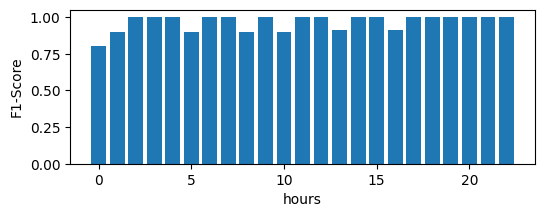

In [23]:
display_metrics(conn_metrics)

In [24]:
print_mistakes(conn_metrics)

0: 2 Identity: ['192.168.1.249 true: Samsung predicted Netatmo', '192.168.1.239 true: Samsung predicted Withings']
1: 1 Identity: ['192.168.1.227 true: TP-Link predicted Samsung']
2: 0 Identity: []
3: 0 Identity: []
4: 0 Identity: []
5: 1 Identity: ['192.168.1.239 true: Samsung predicted TP-Link']
6: 0 Identity: []
7: 0 Identity: []
8: 1 Identity: ['192.168.1.168 true: Google predicted Triby']
9: 0 Identity: []
10: 1 Identity: ['192.168.1.120 true: Triby predicted TP-Link']
11: 0 Identity: []
12: 0 Identity: []
13: 1 Identity: ['192.168.1.249 true: Samsung predicted TP-Link']
14: 0 Identity: []
15: 0 Identity: []
16: 1 Identity: ['192.168.1.120 true: Triby predicted Samsung']
17: 0 Identity: []
18: 0 Identity: []
19: 0 Identity: []
20: 0 Identity: []
21: 0 Identity: []
22: 0 Identity: []


In [25]:
def all_hr_evaluate(df, train_hours,numeric_columns, text_column):
    train_X, train_Y, test_X, test_Y,labels = time_based_traintest_split(df, train_hours,numeric_columns, text_column, False)
    answer = list()
    for i in range(len(test_X)):
        this_X = test_X[i]
        this_Y = test_Y[i]
        this_labels = labels[i]
        score, mistakes = single_evaluate(train_X, train_Y,this_X, this_Y,this_labels)
        answer.append((score, mistakes))
    return answer

def display_all_hr_metrics(metrics):
    scores = [x[0] for x in metrics]
    ut.plot_bar(range(0,len(metrics)), scores, 'hours', 'F1-Score')


In [26]:
all_metrics = all_hr_evaluate(conn_features, 5, conn_nfeatures, conn_tfeatures[0])
for i,x in enumerate(all_metrics):
    print(f'Post Training Hour:{i} Score: {x[0]:.2f} Wrong Ones: {x[1]}')

Post Training Hour:0 Score: 0.91 Wrong Ones: ['192.168.1.120 true: Triby predicted Samsung']
Post Training Hour:1 Score: 1.00 Wrong Ones: []
Post Training Hour:2 Score: 0.90 Wrong Ones: ['192.168.1.120 true: Triby predicted TP-Link']
Post Training Hour:3 Score: 1.00 Wrong Ones: []
Post Training Hour:4 Score: 0.90 Wrong Ones: ['192.168.1.168 true: Google predicted Samsung']
Post Training Hour:5 Score: 1.00 Wrong Ones: []
Post Training Hour:6 Score: 0.90 Wrong Ones: ['192.168.1.120 true: Triby predicted TP-Link']
Post Training Hour:7 Score: 0.90 Wrong Ones: ['192.168.1.120 true: Triby predicted Samsung']
Post Training Hour:8 Score: 1.00 Wrong Ones: []
Post Training Hour:9 Score: 0.91 Wrong Ones: ['192.168.1.249 true: Samsung predicted TP-Link']
Post Training Hour:10 Score: 1.00 Wrong Ones: []
Post Training Hour:11 Score: 1.00 Wrong Ones: []
Post Training Hour:12 Score: 0.91 Wrong Ones: ['192.168.1.120 true: Triby predicted Samsung']
Post Training Hour:13 Score: 0.91 Wrong Ones: ['192.168

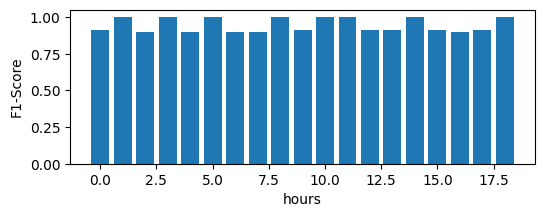

In [27]:
display_all_hr_metrics(all_metrics)

In [28]:
all_metrics = all_hr_evaluate(conn_features, 5, conn_nfeatures, conn_tfeatures[0])
for i,x in enumerate(all_metrics):
    print(f'Post Training Hour:{i} Score: {x[0]:.2f} Wrong Ones: {x[1]}')

Post Training Hour:0 Score: 0.91 Wrong Ones: ['192.168.1.120 true: Triby predicted Samsung']
Post Training Hour:1 Score: 1.00 Wrong Ones: []
Post Training Hour:2 Score: 1.00 Wrong Ones: []
Post Training Hour:3 Score: 1.00 Wrong Ones: []
Post Training Hour:4 Score: 0.90 Wrong Ones: ['192.168.1.168 true: Google predicted TP-Link']
Post Training Hour:5 Score: 1.00 Wrong Ones: []
Post Training Hour:6 Score: 0.90 Wrong Ones: ['192.168.1.120 true: Triby predicted TP-Link']
Post Training Hour:7 Score: 0.90 Wrong Ones: ['192.168.1.120 true: Triby predicted TP-Link']
Post Training Hour:8 Score: 1.00 Wrong Ones: []
Post Training Hour:9 Score: 0.82 Wrong Ones: ['192.168.1.239 true: Samsung predicted TP-Link', '192.168.1.249 true: Samsung predicted TP-Link']
Post Training Hour:10 Score: 1.00 Wrong Ones: []
Post Training Hour:11 Score: 1.00 Wrong Ones: []
Post Training Hour:12 Score: 0.91 Wrong Ones: ['192.168.1.120 true: Triby predicted Samsung']
Post Training Hour:13 Score: 0.91 Wrong Ones: ['192